In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

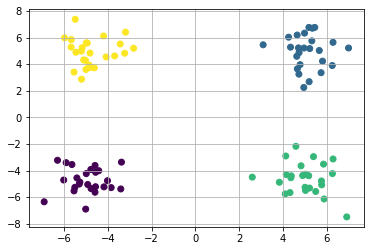

In [2]:
# Set the data X
X = []
labels = []

X.extend(np.random.normal(loc=[-5, -5], size=(25, 2)))
labels.extend([0 for _ in range(25)])

X.extend(np.random.normal(loc=[5, 5], size=(25, 2)))
labels.extend([1 for _ in range(25)])

X.extend(np.random.normal(loc=[5, -5], size=(25, 2)))
labels.extend([2 for _ in range(25)])

X.extend(np.random.normal(loc=[-5, 5], size=(25, 2)))
labels.extend([3 for _ in range(25)])

X = np.array(X)

plt.scatter(X[:,0], X[:,1], c=labels)
plt.grid()
plt.show()

In [3]:
# Set random weights with the same dimensions as the data
# ... or set weights as grid
s = int(np.ceil(np.sqrt(X.shape[0])))
xx = np.linspace(np.min(X[:,0])-1, np.max(X[:,0])+1, s)
yy = np.linspace(np.min(X[:,1])-1, np.max(X[:,1])+1, s)
W = np.array([[x, y] for y in yy for x in xx])

In [4]:
# Use networkx to define topology and neighbourhood connections
# The i'th row of the weights maps to the i'th node in the network

# Using a lattice as an example
G = nx.grid_2d_graph(m=s, n=s)

# Map coordinates to index and index to coordinates
c2i = {c: i for i, c in enumerate(G.nodes())}
i2c = {v: k for k, v in c2i.items()}

In [5]:
# If there are more nodes than weights, append difference to match size
diff = np.abs(len(G.nodes()) - W.shape[0])
if diff > 0:
    W = np.concatenate([W, np.random.random(size=(diff, W.shape[1]))])

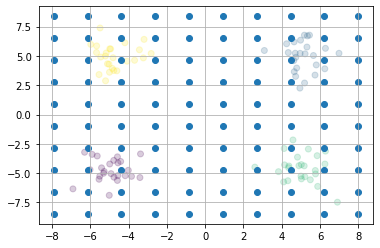

In [6]:
plt.scatter(X[:,0], X[:,1], alpha=0.2, c=labels)
plt.scatter(W[:,0], W[:,1])
plt.grid()
plt.show()

In [7]:
# Function for learning rate
def f1(x, k):
    return np.exp(x * k)

# Function for neighbourhood restraint
def f2(x, s):
    return np.exp((x / (s ** 2)) * -1)

# Compute learning rate
def learning_rate(s, k):
    return f1(x=s, k=k)

# Compute neighbourhood restraint
def restraint(G, best, n, sigma=4):
    dist = nx.shortest_path_length(G, source=best, target=n)
    return np.exp((dist / (sigma ** 2)) * -1)
    return f2(dist, s=sigma)

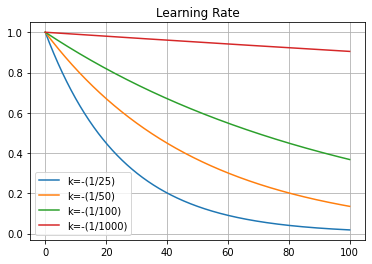

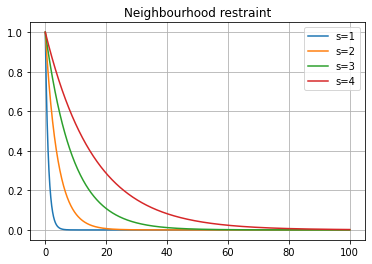

In [8]:
m = 100
x = np.linspace(0, m, 1000)

plt.figure()
for b in [25, 50, 100, 1000]:
    plt.plot(x, f1(x, k=-(1/b)), label=f'k=-(1/{b})')
plt.grid()
plt.title("Learning Rate")
plt.legend()
plt.show()

plt.figure()
for s in [1, 2, 3, 4]:
    plt.plot(x, f2(x, s), label=f's={s}')
plt.grid()
plt.title("Neighbourhood restraint")
plt.legend()
plt.show()

In [9]:
# Keep track of which unit (neuron) won what
winners = {i: [] for i in range(W.shape[0])}

max_iter = 75000

# Start training loop
for s in range(max_iter):
    # Pick random data point
    r_idx = np.random.randint(X.shape[0])
    x = X[r_idx, :]

    # Find the best matching unit (BMU) using Euclidean distance
    x_stack = np.stack([x]*W.shape[0], axis=0)
    dists = np.linalg.norm(x_stack - W, axis=1)
    best_idx = np.argmin(dists)

    # Set learning rate
    k = -(1/1000)
    a = learning_rate(s, k)
    
    # Update weights
    W[best_idx, :] = W[best_idx, :] + a * (x - W[best_idx, :])
    
    # Add the index of the data point to the "won" list
    winners[best_idx].append(r_idx)

    # Update weights of neighbours
    immediate_n = list(G[i2c[best_idx]])
    for n in immediate_n:
        W[c2i[n], :] = W[c2i[n], :] + restraint(G, i2c[best_idx], n) * a * (x - W[c2i[n], :])

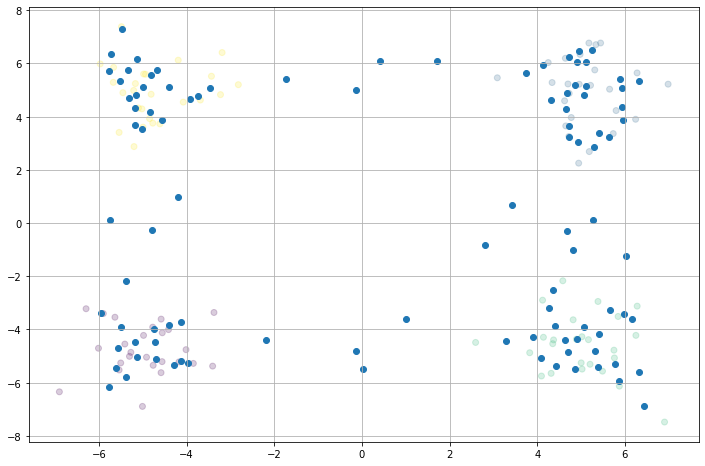

In [10]:
# Plot results with updated weights
plt.figure(figsize=(12, 8))
plt.scatter(X[:,0], X[:,1], alpha=0.2, c=labels)
plt.scatter(W[:,0], W[:,1])
plt.grid()
plt.show()

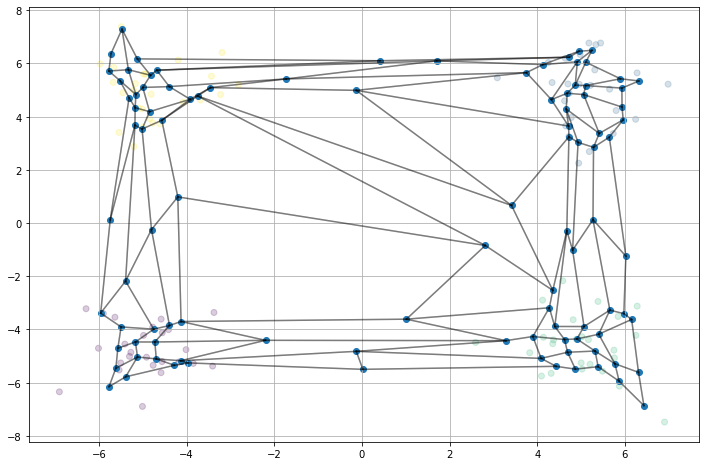

In [11]:
# Plot results with updated connected weights
plt.figure(figsize=(12, 8))
plt.scatter(X[:,0], X[:,1], alpha=0.2, c=labels)

for i in range(W.shape[0]):
    w1 = W[i,:]
    for xy2 in list(G[i2c[i]]):
        w2 = W[c2i[xy2],:]
        plt.plot([w1[0], w2[0]], [w1[1], w2[1]], color='k', alpha=0.3)

plt.scatter(W[:,0], W[:,1])
plt.grid()
plt.show()

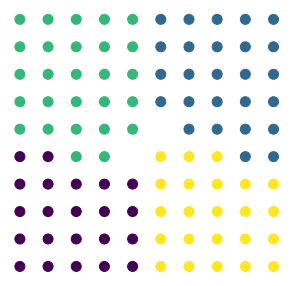

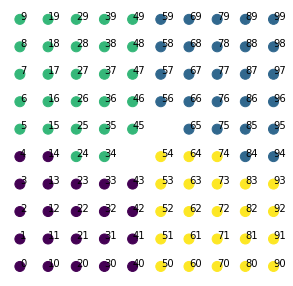

In [12]:
# Match unit to most "won" data point, else sign no label
def best_match(idxs):
    idx = None
    if len(idxs) > 0:
        idx = max(idxs, key=idxs.count)
    
    return idx

unit_match = {i: best_match(idxs) for i, idxs in winners.items()}

# Match unit with the label, if assigned index
unit_label = {i: labels[idx] for i, idx in unit_match.items() if idx}

# Plot the results as a scatter plot (optional, try heat map)
results = np.array([list(i2c[k]) for k in unit_label.keys()])
pred = list(unit_label.values())

plt.figure(figsize=(5, 5))
plt.scatter(results[:, 0], results[:, 1], c=pred, s=100)
plt.axis('off')
plt.show()

plt.figure(figsize=(5, 5))
plt.scatter(results[:, 0], results[:, 1], c=pred, s=100)

for i, v in unit_match.items():
    if v:
        c = i2c[i]
        plt.text(x=c[0], y=c[1], s=i)

plt.axis('off')
plt.show()

In [13]:
print("Missing points:")
print([k for k, v in unit_match.items() if not v])

Missing points:
[44, 55]


In [14]:
from sklearn.metrics import classification_report

pred = [labels[idx] if idx else -1 for idx in unit_match.values()]
print(classification_report(y_true=labels, y_pred=pred))

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.64      0.56      0.60        25
           1       0.00      0.00      0.00        25
           2       0.00      0.00      0.00        25
           3       0.35      0.32      0.33        25

    accuracy                           0.22       100
   macro avg       0.20      0.18      0.19       100
weighted avg       0.25      0.22      0.23       100



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
